##### Author: Juste Nyirimana

# Recession challenge

In this challenge we are going to predict economic regimes with machine learning algorithms using Pyhton's Scikit Learn package. Credit goes to the different contributors of the [Python and Machine Learning for Asset Management](https://www.coursera.org/learn/python-machine-learning-for-investment-management) course who provided clear examples on how to implement these types of models.
## Table of Contents:
&nbsp;&nbsp;1. [Set Up Environment, Read Data, Data analysis, and Data preprocessing](#1)
   
&nbsp;&nbsp;2. [Methodology](#2)   

&nbsp;&nbsp;3. [Feature Selection](#3)   

&nbsp;&nbsp;4. [Traning Algorithms on Training Dataset](#4)

&nbsp;&nbsp;5. [Evaluate Performances of the Algorithms on Validation Dataset](#5)

## 1. Set Up Environment, Read Data, Data analysis, and Data preprocessing <a id="1"></a>

In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from matplotlib import pyplot as mp
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.stattools import adfuller #to check unit root in time series 

In [3]:
# to increase the display capacity
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
# reading in the data
bigmacro = pd.read_excel('Recession prediction.xlsx', sheet_name="Data")

In [5]:
bigmacro.head(3)

,DATE,level_yield_curve,slope_yield_curve,curvature_yield_curve,BAA_spread,AAA_spread,DJI,real_M2,credit_spread,TED_spread,M2,Dollar_index,Ouput,Income,permits,Civilian_Unemployment_Rate,non_farm_payrol,all_employ-payrol,Insurance_claim_unempl,S&P_500_Index,SWISS_EX,FEDFUNDS,confidence_ind_manufac,IP_manafac,Yen,Recession
0,1969-01-01,6.036667,0.07,0.25,1.29,0.56,0.0,16.081921,-0.73,0.0,569.3,108.1883,38.9808,3608.0,1459,3.4,68984,68494,1091500,103.010002,4.305265,6.30,9.8,36.6924,115.30,0
1,1969-02-01,6.143333,-0.10,0.32,1.26,0.62,0.0,16.064607,-0.64,0.0,571.9,103.7461,39.1039,3622.9,1495,3.4,69248,68712,1098500,98.129997,4.298128,6.61,14.0,36.9567,113.40,0
2,1969-03-01,6.216667,0.07,0.37,1.32,0.66,0.0,16.089636,-0.66,0.0,574.4,100.0000,39.3405,3640.8,1438,3.4,69439,69208,1077800,101.510002,4.300287,6.79,14.2,37.1965,112.96,0


In [4]:
bigmacro.tail(3)

,DATE,level_yield_curve,slope_yield_curve,curvature_yield_curve,BAA_spread,AAA_spread,DJI,real_M2,credit_spread,TED_spread,...,non_farm_payrol,all_employ-payrol,Insurance_claim_unempl,S&P_500_Index,SWISS_EX,FEDFUNDS,confidence_ind_manufac,IP_manafac,Yen,Recession
603,2019-04-01,2.436667,0.17,-0.29,2.13,1.12,0.071645,57.451810,-1.01,2.002381,...,150643,150938,1666250,2945.830078,1.008427,2.42,5.6,105.3860,109.34,0
604,2019-05-01,2.373333,0.15,-0.49,2.10,1.14,-0.067102,57.576688,-0.96,2.098889,...,150796,151610,1675500,2752.060059,1.010727,2.39,4.2,105.5534,109.32,0
605,2019-06-01,2.186667,0.05,-1.13,2.06,1.02,-0.009839,57.936209,-1.04,2.205238,...,151012,152243,1696800,2941.760010,0.987975,2.38,3.4,106.1902,108.70,0


#### Data analysis

In [7]:
bigmacro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606 entries, 0 to 605
Data columns (total 26 columns):
DATE                          606 non-null datetime64[ns]
level_yield_curve             606 non-null float64
slope_yield_curve             606 non-null float64
curvature_yield_curve         606 non-null float64
BAA_spread                    606 non-null float64
AAA_spread                    606 non-null float64
DJI                           606 non-null float64
real_M2                       606 non-null float64
credit_spread                 606 non-null float64
TED_spread                    606 non-null float64
M2                            606 non-null float64
Dollar_index                  606 non-null float64
Ouput                         606 non-null float64
Income                        606 non-null float64
permits                       606 non-null int64
Civilian_Unemployment_Rate    606 non-null float64
non_farm_payrol               606 non-null int64
all_employ-payrol        

In [8]:
bigmacro.Recession.value_counts()#Highly imbalanced

0    516
1     90
Name: Recession, dtype: int64

Text(0.5, 1.0, 'Recession VS Normal')

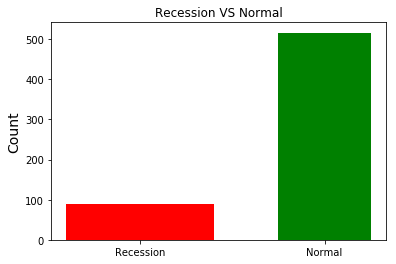

In [10]:
#Visualising recession and normal cases
plt.bar("Recession", bigmacro["Recession"].value_counts()[1], color="red")
plt.bar("Normal", bigmacro["Recession"].value_counts()[0], width=0.5, color="green")
plt.ylabel("Count", fontsize=14)
mp.savefig('imbalance.png',  bbox_inches='tight')
plt.title("Recession VS Normal")

In [11]:
print(bigmacro.DATE.min(),bigmacro.DATE.max())#duration of the dataset

1969-01-01 00:00:00 2019-06-01 00:00:00


In [6]:
#Extracting month from the date column 
bigmacro['month'] = bigmacro['DATE'].dt.month

In [14]:
# investing if there are any hish risks months
bigmacro_month = (bigmacro.groupby(['Recession'])['month']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('month'))

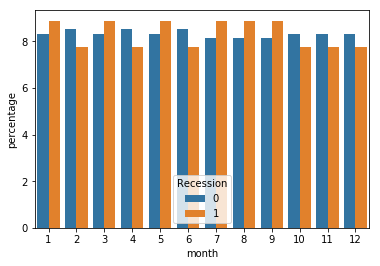

In [16]:
sns.barplot(x="month", y="percentage", hue="Recession", data=bigmacro_weekday)
mp.savefig('monthly.png',  bbox_inches='tight')
#from the graph below we can see that there any high risk months

In [6]:
del bigmacro['month']#deleting the month variable

In [21]:
import datetime
# define periods of recession
rec_spans = []
rec_spans.append([datetime.datetime(1969,6,1), datetime.datetime(1970,5,1)])
rec_spans.append([datetime.datetime(1973,5,1), datetime.datetime(1974,9,1)])
rec_spans.append([datetime.datetime(1979,7,1), datetime.datetime(1980,1,1)])
rec_spans.append([datetime.datetime(1981,1,1), datetime.datetime(1982,5,1)])
rec_spans.append([datetime.datetime(1990,7,1), datetime.datetime(1991,3,1)])
rec_spans.append([datetime.datetime(2001,3,1), datetime.datetime(2001,11,1)])
rec_spans.append([datetime.datetime(2007,12,1), datetime.datetime(2009,6,1)])

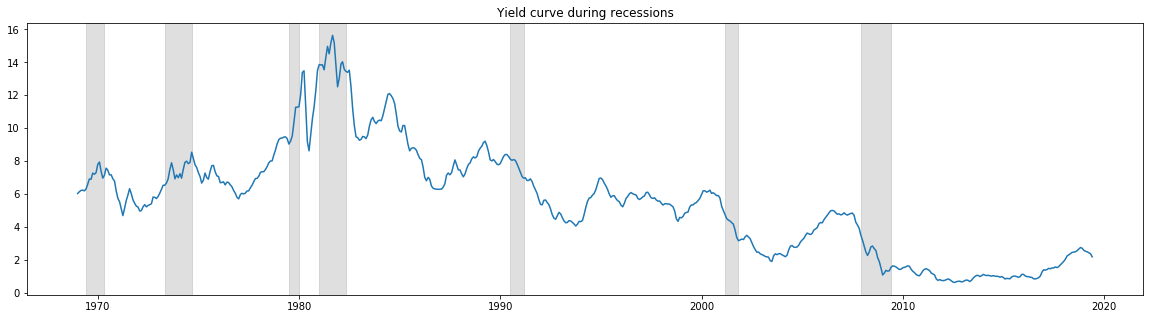

In [25]:
#the yield curve drops during the recession.
sample_range = pd.date_range(start='1969-1-1', end='2019-6-1', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, bigmacro.level_yield_curve.values)
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
#plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Yield curve during recessions')
mp.savefig('yield.png',  bbox_inches='tight')
plt.show()

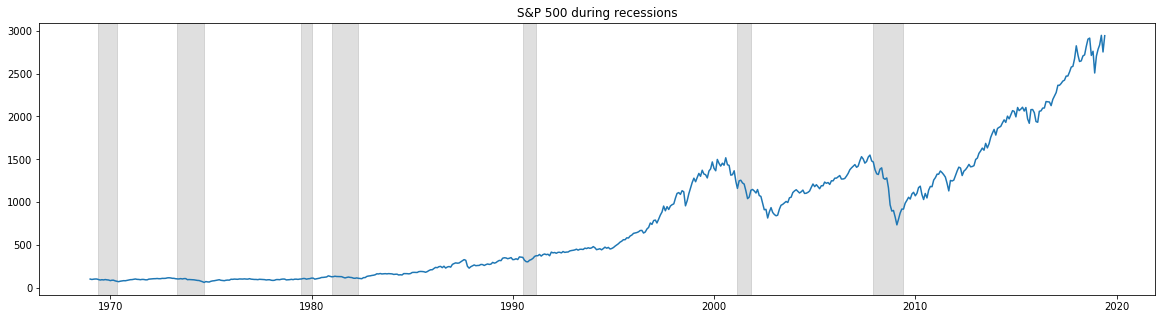

In [26]:
#the sp500 also drops significantly during recessions. It is also not a good indicator of an upcoming recession.
sample_range = pd.date_range(start='1969-1-1', end='2019-6-1', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, bigmacro['S&P_500_Index'].values)
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
#plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('S&P 500 during recessions')
mp.savefig('s_and_p.png',  bbox_inches='tight')
plt.show()

#### Data preprocessing

In [5]:
bigmacro.loc[(bigmacro['Recession'] > 0), 'Regime'] = 'Recession'

In [6]:
bigmacro.loc[(bigmacro['Recession'] == 0), 'Regime'] = 'Normal'

In [7]:
del bigmacro['Recession']

In [8]:
# Add lags
for col in bigmacro.drop(['DATE', 'Regime'], axis=1):
    for n in [3,6,9,12,18]:
        bigmacro['{} {}M lag'.format(col, n)] = bigmacro[col].shift(n).ffill().values

# 1 month ahead prediction
bigmacro["Regime"]=bigmacro["Regime"].shift(-1)

bigmacro=bigmacro.dropna(axis=0)

In [11]:
bigmacro.shape

(587, 146)

In [9]:
#check stationarity
from statsmodels.tsa.stattools import adfuller #to check unit root in time series 
threshold=0.01 #significance level
for column in bigmacro.drop(['DATE','Regime'], axis=1):
    result=adfuller(bigmacro[column])
    if result[1]>threshold:
        bigmacro[column]=bigmacro[column].diff()
bigmacro=bigmacro.dropna(axis=0)

In [10]:
threshold=0.01 #significance level
for column in bigmacro.drop(['DATE','Regime'], axis=1):
    result=adfuller(bigmacro[column])
    if result[1]>threshold:
        bigmacro[column]=bigmacro[column].diff()
bigmacro=bigmacro.dropna(axis=0)

In [11]:
threshold=0.01 #significance level
for column in bigmacro.drop(['DATE','Regime'], axis=1):
    result=adfuller(bigmacro[column])
    if result[1]>threshold:
        print(column)
bigmacro=bigmacro.dropna(axis=0)      

In [12]:
# Standardize
from sklearn.preprocessing import StandardScaler
features=bigmacro.drop(['DATE','Regime'],axis=1)
col_names=features.columns

scaler=StandardScaler()
scaler.fit(features)
standardized_features=scaler.transform(features)
standardized_features.shape
df=pd.DataFrame(data=standardized_features,columns=col_names)
df.insert(loc=0,column="DATE", value=bigmacro['DATE'].values)
df.insert(loc=1,column='Regime', value=bigmacro['Regime'].values)
df.head()
df.shape

(585, 146)

In [13]:
df.to_csv("Dataset_Cleaned.csv", index=False)

In [3]:
df=pd.read_csv('Dataset_Cleaned.csv')

Label = df["Regime"].apply(lambda regime: 1. if regime == 'Normal' else 0.)
df.insert(loc=2, column="Label", value=Label.values)

df.head()


,DATE,Regime,Label,level_yield_curve,slope_yield_curve,curvature_yield_curve,BAA_spread,AAA_spread,DJI,real_M2,...,IP_manafac 3M lag,IP_manafac 6M lag,IP_manafac 9M lag,IP_manafac 12M lag,IP_manafac 18M lag,Yen 3M lag,Yen 6M lag,Yen 9M lag,Yen 12M lag,Yen 18M lag
0,1970-09-01,Normal,1.0,0.038661,-0.482877,-0.080518,-0.515019,-0.362386,0.121163,0.347132,...,-0.218620,-0.055275,0.818354,0.272334,0.218340,-0.166673,-0.580060,2.558571,0.454688,-0.560456
1,1970-10-01,Normal,1.0,-0.766281,-0.360970,-0.152634,-0.400863,0.259015,0.121163,-0.191981,...,0.166312,-0.298652,0.275543,0.841964,0.582684,-0.179932,-0.593362,0.414020,1.048303,1.363798
2,1970-11-01,Normal,1.0,-0.464428,-0.239063,-0.080518,-0.243899,0.259015,0.121163,-0.357622,...,-0.410042,0.271031,0.958373,0.684373,-0.132848,-0.179932,1.801007,-0.578827,-1.814242,1.363798
3,1970-12-01,Normal,1.0,-1.951334,-0.125283,-0.212730,0.084300,0.259015,0.121163,0.114647,...,0.492599,-0.221658,-0.059420,0.820149,0.005733,0.363672,-0.167697,-0.578827,2.552129,-1.499753
4,1971-01-01,Normal,1.0,-1.515324,-0.157792,-0.212730,0.184186,0.553363,0.121163,0.163182,...,0.416553,0.164532,-0.302491,0.276871,-0.183719,0.429965,-0.180999,-0.592065,0.415114,3.131502


In [4]:
df=df.rename(columns = {'DATE':'Date'})

In [16]:
df.tail()

,Date,Regime,Label,level_yield_curve,slope_yield_curve,curvature_yield_curve,BAA_spread,AAA_spread,DJI,real_M2,...,IP_manafac 3M lag,IP_manafac 6M lag,IP_manafac 9M lag,IP_manafac 12M lag,IP_manafac 18M lag,Yen 3M lag,Yen 6M lag,Yen 9M lag,Yen 12M lag,Yen 18M lag
580,2019-01-01,Normal,1.0,-0.408529,-1.019268,-0.032442,0.098569,0.651479,-0.831911,0.509254,...,-0.374890,0.589655,0.708502,-0.876177,-0.499121,-0.126898,0.470802,0.122785,0.243625,-0.116899
581,2019-02-01,Normal,1.0,-0.151395,-1.116794,0.051693,0.027222,-0.068038,0.107981,-1.573949,...,0.163354,0.610954,-1.563529,1.756793,-0.697870,1.053121,0.244667,1.459820,-0.178502,-0.364769
582,2019-03-01,Normal,1.0,-0.084316,-1.157430,-0.200711,-0.086934,0.030078,-0.552117,0.489278,...,1.001260,-0.184122,1.241025,-0.095029,-0.424042,0.840983,0.563916,0.466972,-0.956797,0.470161
583,2019-04-01,Normal,1.0,-0.162575,-1.254955,-0.044461,-0.129743,0.095488,2.052365,-0.416711,...,-1.267090,-0.378439,0.584700,0.710202,2.239335,-2.102434,-0.127791,0.466972,0.124902,0.144017
584,2019-05-01,Normal,1.0,-0.184934,-1.271209,-0.236768,-0.172551,0.062783,-1.687596,0.268146,...,-1.164940,0.161564,0.605973,-1.563782,0.381479,1.609983,1.056092,0.241927,1.457238,-1.082287


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Columns: 711 entries, Date to INVEST 18M lag
dtypes: float64(709), object(2)
memory usage: 3.8+ MB


## 2. Methodology <a id="2"></a>

This a classification problem. We have two binary outcomes that we want to predict with certain variables. Here we will summarize our approach to predict recessions with machine learning algorithms.

1. We will perform feature selection before making our forecasts. We will use $L_1$ regularized logistic regression for that purpose.

2. Separate dataset into training and validation datasets. Split based dataset based on time: the period over 1969-2000 is selected for training and the period over 2000-2019 is kept for validation

3. Evaluate performances of the machine learning algorithms on training dataset with cross validation (CV). Since we have time series structure we will use a special type of CV function in Python,__[`TimeSeriesSplit`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit)__. We will use Receiver operating characteristic (ROC) as scoring metric in our models. Related Python functions for this metric are __[`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score)__  and  __[`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)__.

4. Select the best performing models based on average accuracy and standard deviation of the CV results. We will take logistic regression as a benchmark model since this is the traditional method has been used to approach this problem.

5. Then we make predictions on the validation dataset with selected models. First, we use __[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)__ for selected model on training dataset to find best combination of parameters for the model. Then we evaluate the model on validation dataset and report accuracy metrics and feature importance results.

## 3. Feature Selection with $L_1$ Penalty <a id="3"></a>

In [6]:
# Time Series Split
df_idx = df[df.Date == '1992-01-01'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]

In [18]:
print(len(df_training_features),len(df_training_targets),len(df_targets))
print(len(df_validation_features),len(df_validation_targets),len(df_features))

363 363 585
222 222 585


In [7]:
scoring="roc_auc"
kfold= model_selection.TimeSeriesSplit(n_splits=3)
seed=8

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C)

model=LogisticRegression(max_iter=10000,penalty='l1')
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(X=df_features,
                                                                       y=df_targets).best_estimator_

LR_penalty

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [8]:
X=df_features
y=df_targets
lr_l1 = LogisticRegression(C=0.1, max_iter=10000,penalty="l1").fit(X,y)
model = SelectFromModel(lr_l1,prefit=True)
feature_idx = model.get_support()
feature_name = X.columns[feature_idx]
X_new = model.transform(X)
X_new.shape

(585, 26)

In [20]:
feature_name

Index(['slope_yield_curve', 'DJI', 'TED_spread', 'Ouput', 'Income', 'permits',
       'non_farm_payrol', 'Insurance_claim_unempl', 'S&P_500_Index',
       'FEDFUNDS', 'IP_manafac', 'slope_yield_curve 3M lag',
       'slope_yield_curve 6M lag', 'slope_yield_curve 9M lag', 'DJI 3M lag',
       'DJI 6M lag', 'credit_spread 9M lag', 'Income 3M lag',
       'permits 18M lag', 'S&P_500_Index 3M lag', 'S&P_500_Index 6M lag',
       'SWISS_EX 12M lag', 'FEDFUNDS 3M lag', 'confidence_ind_manufac 3M lag',
       'confidence_ind_manufac 18M lag', 'IP_manafac 3M lag'],
      dtype='object')

In [9]:
df_2=df[feature_name]
df_2.insert(loc=0, column="Date", value=df['Date'].values)
df_2.insert(loc=1, column="Regime", value=df['Regime'].values)
df_2.insert(loc=2, column="Label", value=df['Label'].values)

df_2.head()
df_2.shape

(585, 29)

In [18]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 44 columns):
Date                     695 non-null object
Regime                   695 non-null object
Label                    695 non-null float64
DPCERA3M086SBEA          695 non-null float64
IPDMAT                   695 non-null float64
CLAIMSx                  695 non-null float64
PAYEMS                   695 non-null float64
SRVPRD                   695 non-null float64
USWTRADE                 695 non-null float64
USFIRE                   695 non-null float64
M2REAL                   695 non-null float64
S&P div yield            695 non-null float64
BAA                      695 non-null float64
TB3SMFFM                 695 non-null float64
IPMAT 9M lag             695 non-null float64
HWIURATIO 9M lag         695 non-null float64
HWIURATIO 12M lag        695 non-null float64
UEMP5TO14 9M lag         695 non-null float64
USGOOD 9M lag            695 non-null float64
DMANEMP 9M lag         

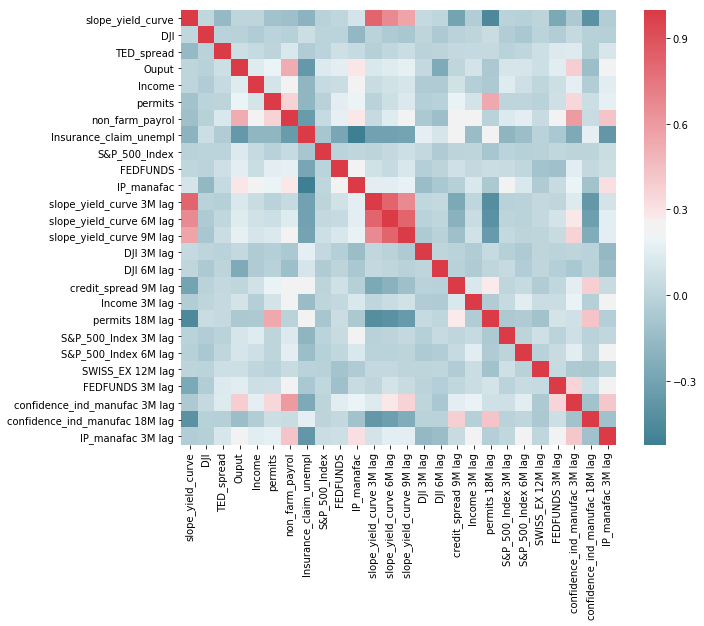

In [29]:
corr = df_2.drop(['Date','Regime','Label'],axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True), square=True)
mp.savefig('corr.png',  bbox_inches='tight')

## 4. Training Algorithms on Training Dataset <a id="3"></a>

For a detail description of the machine learning algorithms you can check scikit-learn's documentation __[here](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)__.

In [10]:
df=df_2
df.shape

(585, 29)

In [11]:
# Time Series Split
df_idx = df[df.Date == '1992-01-01'].index[0]

df_targets=df['Label'].values
df_features=df.drop(['Regime','Date','Label'], axis=1)

df_training_features = df.iloc[:df_idx,:].drop(['Regime','Date','Label'], axis=1)
df_validation_features = df.iloc[df_idx:, :].drop(['Regime','Date','Label'], axis=1)

df_training_targets = df['Label'].values
df_training_targets=df_training_targets[:df_idx]

df_validation_targets = df['Label'].values
df_validation_targets=df_validation_targets[df_idx:]



LR: 0.747798 (0.116726)
LR_L1: 0.809965 (0.081937)
LR_L2: 0.814727 (0.084314)
LDA: 0.705135 (0.096181)
KNN: 0.724947 (0.120318)
GB: 0.667437 (0.126131)
ABC: 0.657001 (0.176192)
RF: 0.715118 (0.072369)
XGB: 0.838180 (0.048576)


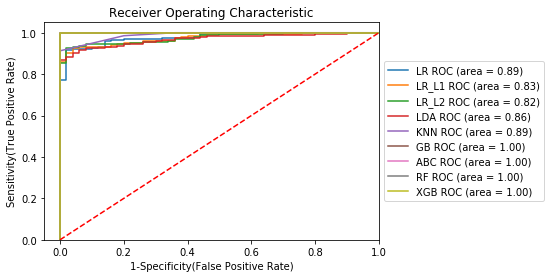

In [26]:
seed=8
scoring='roc_auc' 
kfold = model_selection.TimeSeriesSplit(n_splits=3) 
models = []

models.append(('LR', LogisticRegression(C=1e09)))
models.append(('LR_L1', LogisticRegression(penalty = 'l1')))
models.append(('LR_L2', LogisticRegression(penalty = 'l2')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('GB', GradientBoostingClassifier()))
models.append(('ABC', AdaBoostClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB', xgb.XGBClassifier()))

results = []
names = []
lb = preprocessing.LabelBinarizer()

#from sklearn.utils import shuffle
#df_training_features, df_training_targets = shuffle(df_training_features, df_training_targets)

for name, model in models:
    cv_results = model_selection.cross_val_score(estimator = model, X = df_training_features, 
                                                 y = lb.fit_transform(df_training_targets), cv=kfold, scoring = scoring)
    
    model.fit(df_training_features, df_training_targets) # train the model
    fpr, tpr, thresholds = metrics.roc_curve(df_training_targets, model.predict_proba(df_training_features)[:,1])
    auc = metrics.roc_auc_score(df_training_targets,model.predict(df_training_features))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (name, auc))
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#mp.savefig('alg_perf.png',  bbox_inches='tight')
plt.show() 
warnings.filterwarnings('ignore')

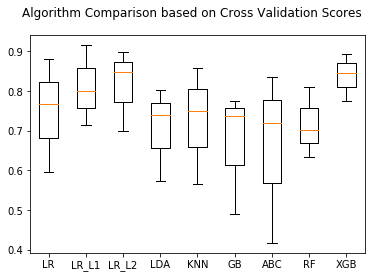

In [27]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison based on Cross Validation Scores')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
#mp.savefig('box_alg.png',  bbox_inches='tight')
plt.show()

## 4. Evaluate Performances of the Algorithms on Validation Dataset <a id="4"></a>

### Logistic Regression

Logistic regression is the most commonly used statistical model for binary classification. It uses the logit model of relating log-odds of the dependent variable linearly with the predictor (explanatory) variables to learn a form of the following logistic function that is used to separate instances of the two different classes. 

\begin{align*}
Pr(y=1|x) = h_\beta(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1  x)}} \text{ where $\beta_0$ is the intercept and $\beta$ is the vector of trained weights}
\end{align*}

The function returns a probability measure of which class a new instance is given its features, this measure is then used to make the final classification with some probability threshold, traditionally being 0.5.

The specific logistic function is learned through gradient descent which focuses on minimizing error calculated through some cost function. A typical approach is to use the following maximum-likelihood estimator to minimize error in predicted probabilities.

\begin{align*}
& J(\beta) = -\frac{1}{N}\sum_{i=1}^Ny_ilog(h_\beta(x_i)) + (1 - y_i)log(1 - h_\beta(x_i)) \\
& \text{ where $N$ is the number of observations, $h_\beta(x)$ is as defined above, and $y_i$ is the predicted class}
\end{align*}

A regularization term 

\begin{align*}
\lambda\sum_{i=1}^N|\beta_i| \text{ where $\lambda$ is a regularization parameter, }
\end{align*}

is often added to the cost function to prevent overfitting by penalizing large coefficients. This regularization can be L1 or L2 penalty depending on the problem at hand.

In [14]:
model=LogisticRegression(C=1e09) # high penalty 
LR=model.fit(df_training_features,df_training_targets)
training_predictions=LR.predict(df_training_features)
prob_predictions = LR.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR.predict_proba(df_validation_features), axis=0)

In [15]:
import datetime
# define periods of recession
rec_spans = []
#rec_spans.append([datetime.datetime(1969,6,1), datetime.datetime(1970,5,1)])
rec_spans.append([datetime.datetime(1973,5,1), datetime.datetime(1974,9,1)])
rec_spans.append([datetime.datetime(1979,7,1), datetime.datetime(1980,1,1)])
rec_spans.append([datetime.datetime(1981,1,1), datetime.datetime(1982,5,1)])
rec_spans.append([datetime.datetime(1990,7,1), datetime.datetime(1991,3,1)])
rec_spans.append([datetime.datetime(2001,3,1), datetime.datetime(2001,11,1)])
rec_spans.append([datetime.datetime(2007,12,1), datetime.datetime(2009,6,1)])

In [2]:
rec_spans 

[[datetime.datetime(1960, 4, 1, 0, 0), datetime.datetime(1961, 2, 1, 0, 0)],
 [datetime.datetime(1969, 12, 1, 0, 0), datetime.datetime(1970, 11, 1, 0, 0)],
 [datetime.datetime(1973, 11, 1, 0, 0), datetime.datetime(1975, 3, 1, 0, 0)],
 [datetime.datetime(1980, 1, 1, 0, 0), datetime.datetime(1980, 6, 1, 0, 0)],
 [datetime.datetime(1981, 7, 1, 0, 0), datetime.datetime(1982, 10, 1, 0, 0)],
 [datetime.datetime(1990, 7, 1, 0, 0), datetime.datetime(1991, 2, 1, 0, 0)],
 [datetime.datetime(2001, 3, 1, 0, 0), datetime.datetime(2001, 10, 1, 0, 0)],
 [datetime.datetime(2007, 12, 1, 0, 0), datetime.datetime(2009, 5, 1, 0, 0)]]

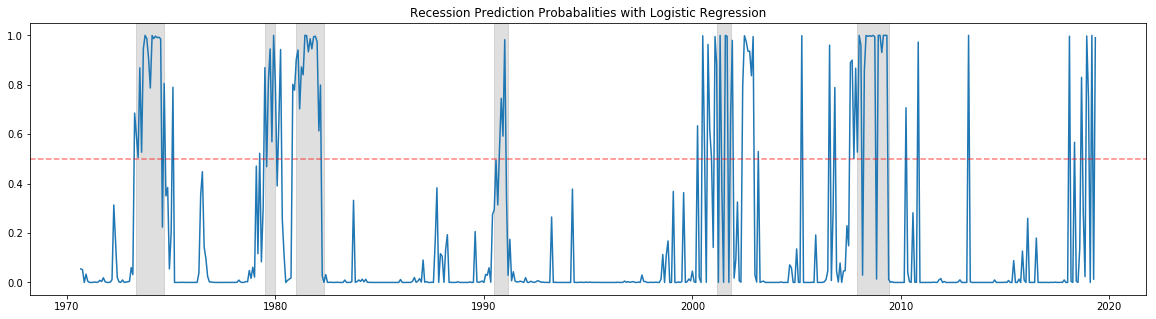

In [16]:
sample_range = pd.date_range(start='9/1/1970', end='5/1/2019', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Logistic Regression')
#mp.savefig('plot1.png',  bbox_inches='tight')
plt.show()

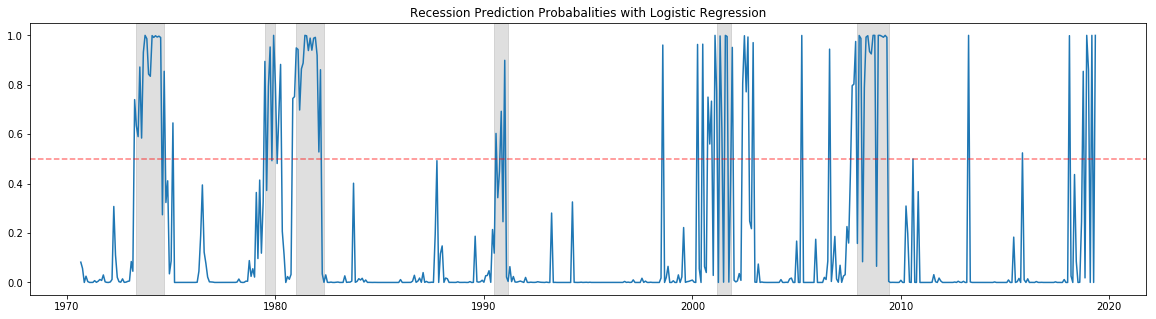

In [16]:
sample_range = pd.date_range(start='9/1/1970', end='5/1/2019', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Logistic Regression')
#mp.savefig('plot1.png',  bbox_inches='tight')
plt.show()

### Logistic Regression with Regularization

In [17]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.reciprocal([0.00000001, 0.00000005, 0.0000001, 0.0000005, 0.000001, 0.000005, 0.00001, 0.00005, 
                         0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000, 5000])

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)


model=LogisticRegression(max_iter=10000)
LR_penalty=model_selection.GridSearchCV(estimator=model, param_grid= hyperparameters,
                                        cv=kfold, scoring=scoring).fit(df_training_features,
                                                                       df_training_targets).best_estimator_
training_predictions=LR_penalty.predict(df_training_features)

In [18]:
prob_predictions = LR_penalty.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, LR_penalty.predict_proba(df_validation_features), axis=0)

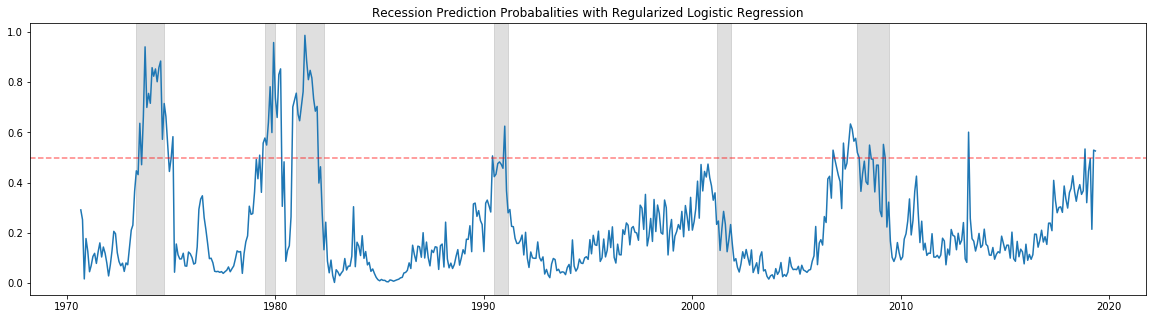

In [19]:
sample_range = pd.date_range(start='9/1/1970', end='5/1/2019', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with Regularized Logistic Regression')
#mp.savefig('plot2.png',  bbox_inches='tight')
plt.show()

### XGBoosting

In [20]:
xgboost = model_selection.GridSearchCV(estimator=xgb.XGBClassifier(),
                                       param_grid={'booster': ['gbtree']},
                                       scoring=scoring, cv=kfold).fit(df_training_features, 
                                                                      lb.fit_transform(df_training_targets)).best_estimator_
xgboost.fit(df_training_features, df_training_targets)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [21]:
prob_predictions = xgboost.predict_proba(df_training_features)
prob_predictions = np.append(prob_predictions, xgboost.predict_proba(df_validation_features), axis=0)

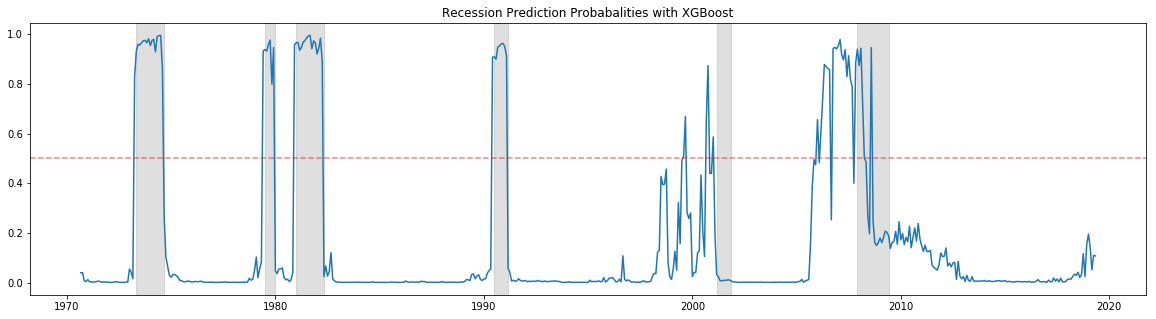

In [22]:
sample_range = pd.date_range(start='9/1/1970', end='5/1/2019', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with XGBoost')
#mp.savefig('plot3.png',  bbox_inches='tight')

plt.show()

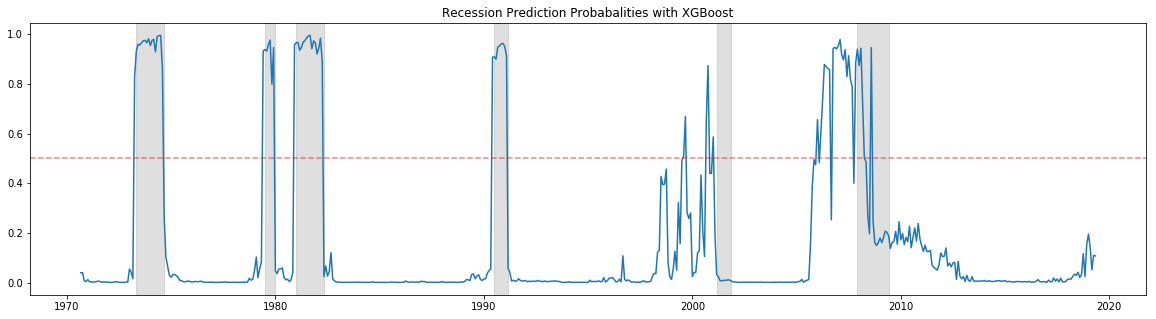

In [40]:
sample_range = pd.date_range(start='9/1/1970', end='5/1/2019', freq='MS')

plt.figure(figsize=(20,5))
plt.plot(sample_range.to_series().values, prob_predictions[:,0])
for i in range(len(rec_spans)):
    plt.axvspan(rec_spans[i][0], rec_spans[i][len(rec_spans[i]) - 1], alpha=0.25, color='grey')
plt.axhline(y=0.5, color='r', ls='dashed', alpha = 0.5)
plt.title('Recession Prediction Probabalities with XGBoost')
#mp.savefig('plot3.png',  bbox_inches='tight')
plt.show()

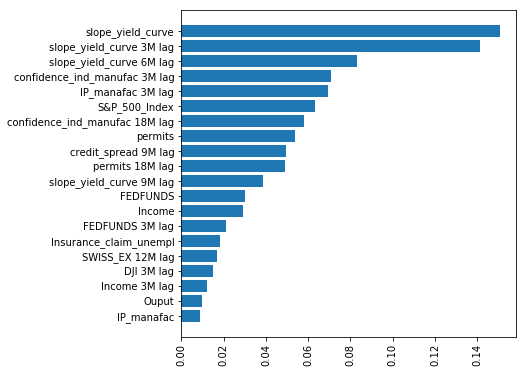

In [23]:
# find feature importances
headers = df.drop(['Regime','Label', 'Date'], axis=1).columns.values.tolist()
xgboost_importances = pd.DataFrame(xgboost.feature_importances_, index = headers, columns = ['Relative Importance'])
_ = xgboost_importances.sort_values(by = ['Relative Importance'], ascending = False, inplace=True)
xgboost_importances = xgboost_importances[xgboost_importances['Relative Importance']>0].iloc[:20]

# display importances in bar-chart and pie-chart
fig = plt.figure(figsize=(6,6))
plt.xticks(rotation='90')
plt.barh(y=np.arange(len(xgboost_importances)), width=xgboost_importances['Relative Importance'], align='center', tick_label=xgboost_importances.index)
plt.gca().invert_yaxis()
#mp.savefig('feature_importance.png',  bbox_inches='tight')
plt.show()

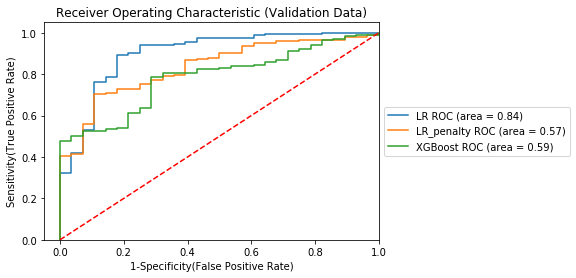

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, LR_penalty.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,LR_penalty.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_validation_targets, xgboost.predict_proba(df_validation_features)[:,1])
auc = metrics.roc_auc_score(df_validation_targets,xgboost.predict(df_validation_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Validation Data)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#mp.savefig('ROC1.png',  bbox_inches='tight')
plt.show() 

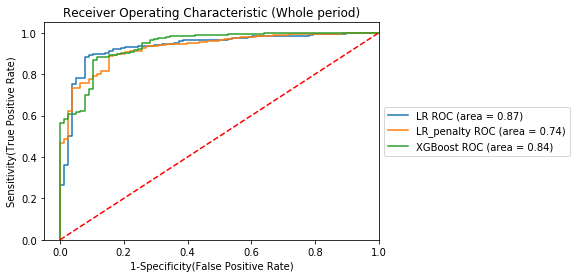

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR', auc))


fpr, tpr, thresholds = metrics.roc_curve(df_targets, LR_penalty.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,LR_penalty.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('LR_penalty', auc))

fpr, tpr, thresholds = metrics.roc_curve(df_targets, xgboost.predict_proba(df_features)[:,1])
auc = metrics.roc_auc_score(df_targets,xgboost.predict(df_features))
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('XGBoost', auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic (Whole period)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#mp.savefig('ROC2.png',  bbox_inches='tight')
plt.show() 